In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from numpy import trapz

In [6]:
# Deterministic model
def model_non_stochastic(t, x, P):
    IP3, v1, v2, v3, a2, d1, d2, d3, d5, k3 = P
    c0 = 2
    c1 = 0.185

    Ca, h = x
    CaER = (c0 - Ca) / c1
    pinf = IP3 / (IP3 + d1)
    ninf = Ca / (Ca + d5)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)

    alphah = hinf / tauh
    betah = (1 - hinf) / tauh
    dh = alphah * (1 - h) - betah * h
    dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)

    return np.array([dCa, dh])

# Stochastic model
def model_stochastic(t, x, P, dt):
    IP3, v1, v2, v3, a2, d1, d2, d3, d5, k3 = P
    c0 = 2
    c1 = 0.185

    Ca, h = x
    CaER = (c0 - Ca) / c1
    pinf = IP3 / (IP3 + d1)
    ninf = Ca / (Ca + d5)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)

    alphah = hinf / tauh
    betah = (1 - hinf) / tauh
    dh = alphah * (1 - h) - betah * h
    dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)

    # Stochastic noise
    Nd = 2
    gamma1, gamma2 = np.random.rand(2)
    gh = np.sqrt(-2 * (alphah * (1 - h) + betah * h) * np.log(gamma1) / Nd) * np.sin(2 * np.pi * gamma2)
    dh += gh * np.sqrt(dt)

    return np.array([dCa, dh])

In [7]:
# Simulation loop (deterministic + stochastic)
def simulate_bifurcation(stochastic=False, seed=None):
    if seed is not None:
        np.random.seed(seed)

    dt = 0.01
    t_start = 1
    t_end = 600
    tspan = np.arange(t_start, t_end + dt, dt)
    num_steps = len(tspan)
    y02 = np.array([2.0, 0.01])

    A = np.array([[0, 1.5], [5, 8], [0, 0.5], [0.7, 1.2], [0, 0.5],
                  [0, 0.5], [0, 2], [0, 1.5], [0, 0.2], [0, 0.3]])

    Min_Ca = np.full((500, 10), np.nan)
    Max_Ca = np.full((500, 10), np.nan)
    Freq_Ca = np.full((500, 10), np.nan)
    AUC_Ca = np.full((500, 10), np.nan)
    PD = np.full((500, 10), np.nan)

    for Para in range(10):
        print(f"Parameter index: {Para + 1}")
        P = [0.5, 6, 0.11, 0.9, 0.2, 0.13, 1.049, 0.9434, 0.0823, 0.1]
        Pararange = np.linspace(A[Para, 0], A[Para, 1], 500)

        for mul in range(500):
            P[Para] = Pararange[mul]
            y = np.zeros((2, num_steps))
            y[:, 0] = y02

            for n in range(num_steps - 1):
                if stochastic:
                    f = model_stochastic(tspan[n], y[:, n], P, dt)
                else:
                    f = model_non_stochastic(tspan[n], y[:, n], P)
                y[:, n + 1] = y[:, n] + dt * f

            signal_soma = y[0, int(300 / dt):]
            minCa = np.min(signal_soma)
            maxCa = np.max(signal_soma)
            aucCa = trapz(signal_soma, dx=dt)
            peaks, _ = find_peaks(signal_soma, distance=int(10 / dt), height=1.1 * minCa)

            Min_Ca[mul, Para] = minCa
            Max_Ca[mul, Para] = maxCa
            Freq_Ca[mul, Para] = len(peaks)
            AUC_Ca[mul, Para] = aucCa
            PD[mul, Para] = Pararange[mul]

    return Min_Ca, Max_Ca, Freq_Ca, AUC_Ca, PD

In [8]:
min, max, freq, auc, pd = simulate_bifurcation()

Parameter index: 1
Parameter index: 2
Parameter index: 3
Parameter index: 4
Parameter index: 5


C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  tauh = 1 / (a2 * (Q2 + Ca))


Parameter index: 6
Parameter index: 7
Parameter index: 8
Parameter index: 9
Parameter index: 10


C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:18: RuntimeWarning: overflow encountered in scalar multiply
  dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)
C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:10: RuntimeWarning: invalid value encountered in scalar divide
  ninf = Ca / (Ca + d5)
C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:15: RuntimeWarning: invalid value encountered in scalar divide
  alphah = hinf / tauh
C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  betah = (1 - hinf) / tauh
C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:18: RuntimeWarning: overflow encountered in scalar power
  dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)
C:\Users\asus2\AppData\Local\Temp\ipykernel_10176\2410542936.py:18: Runtim

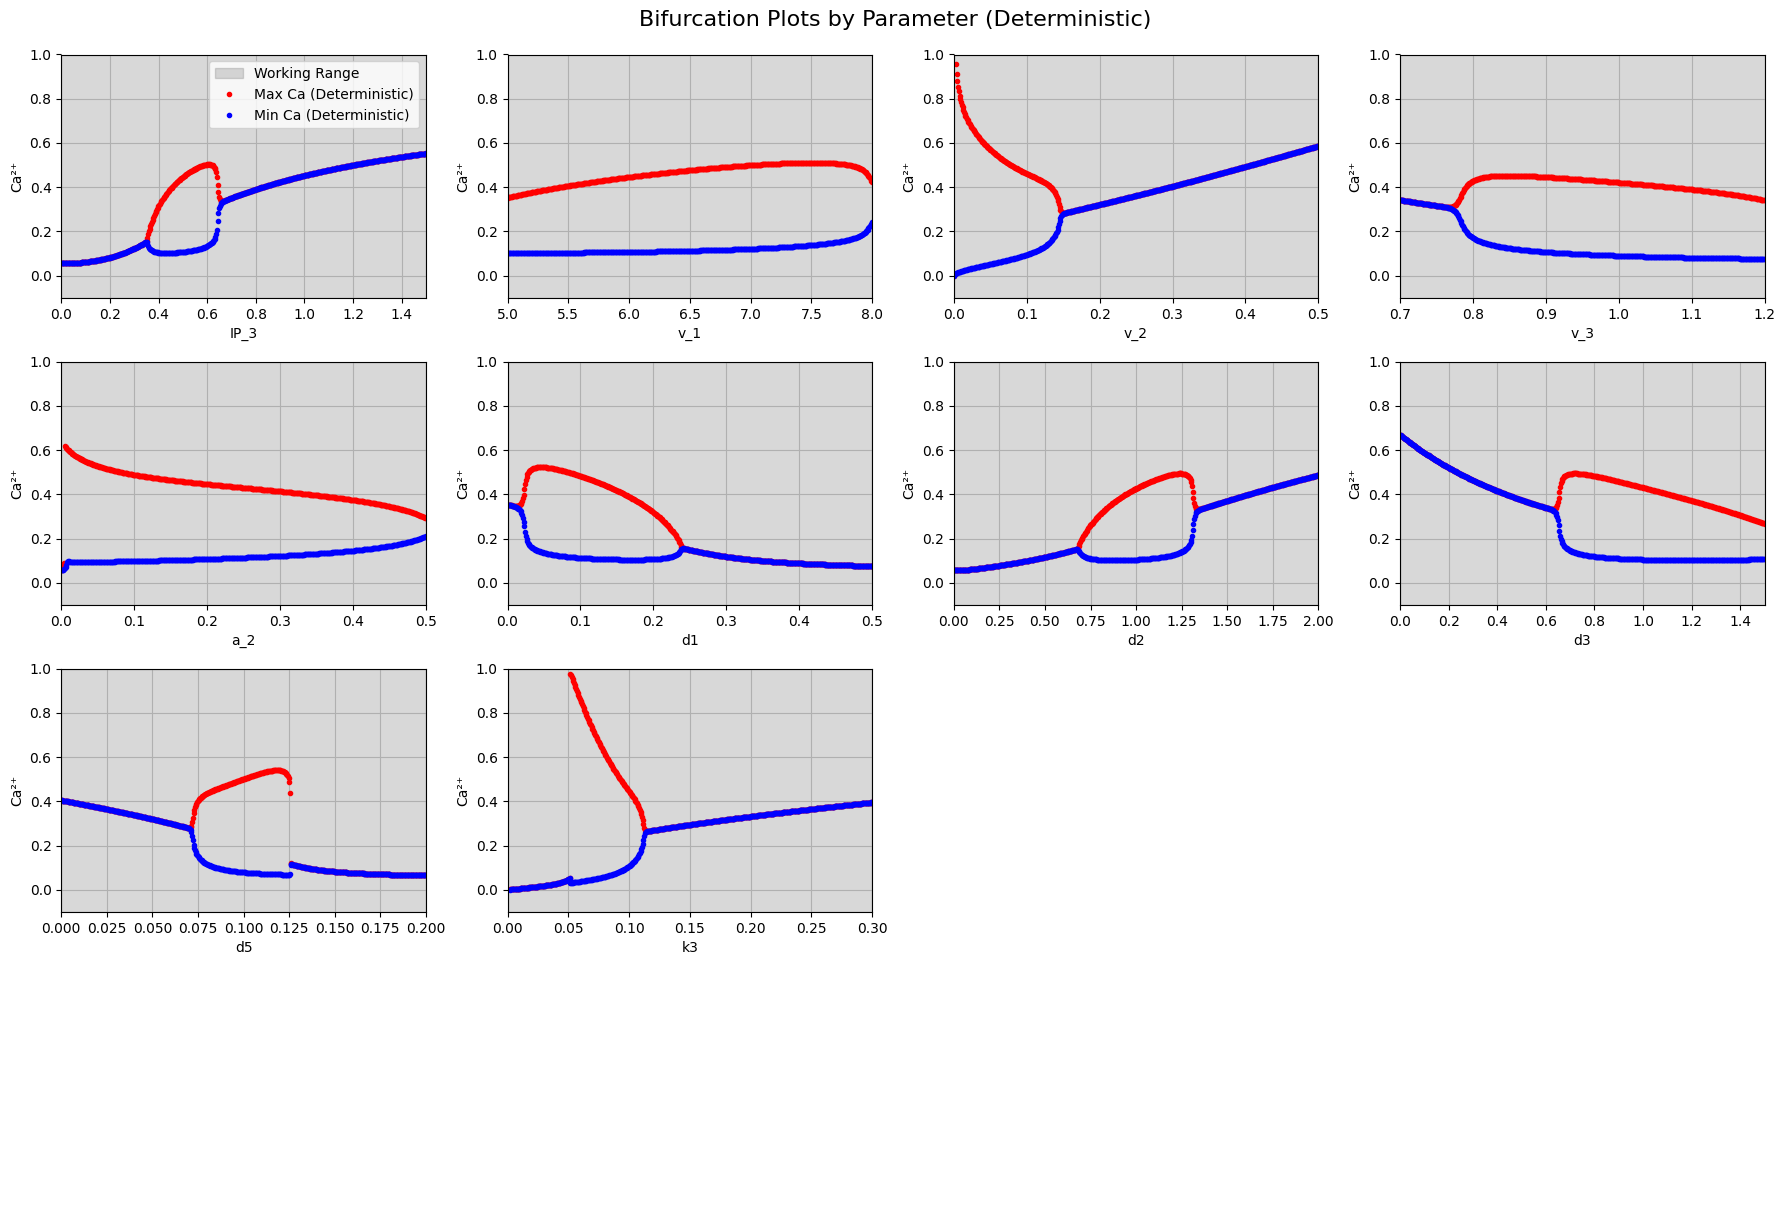

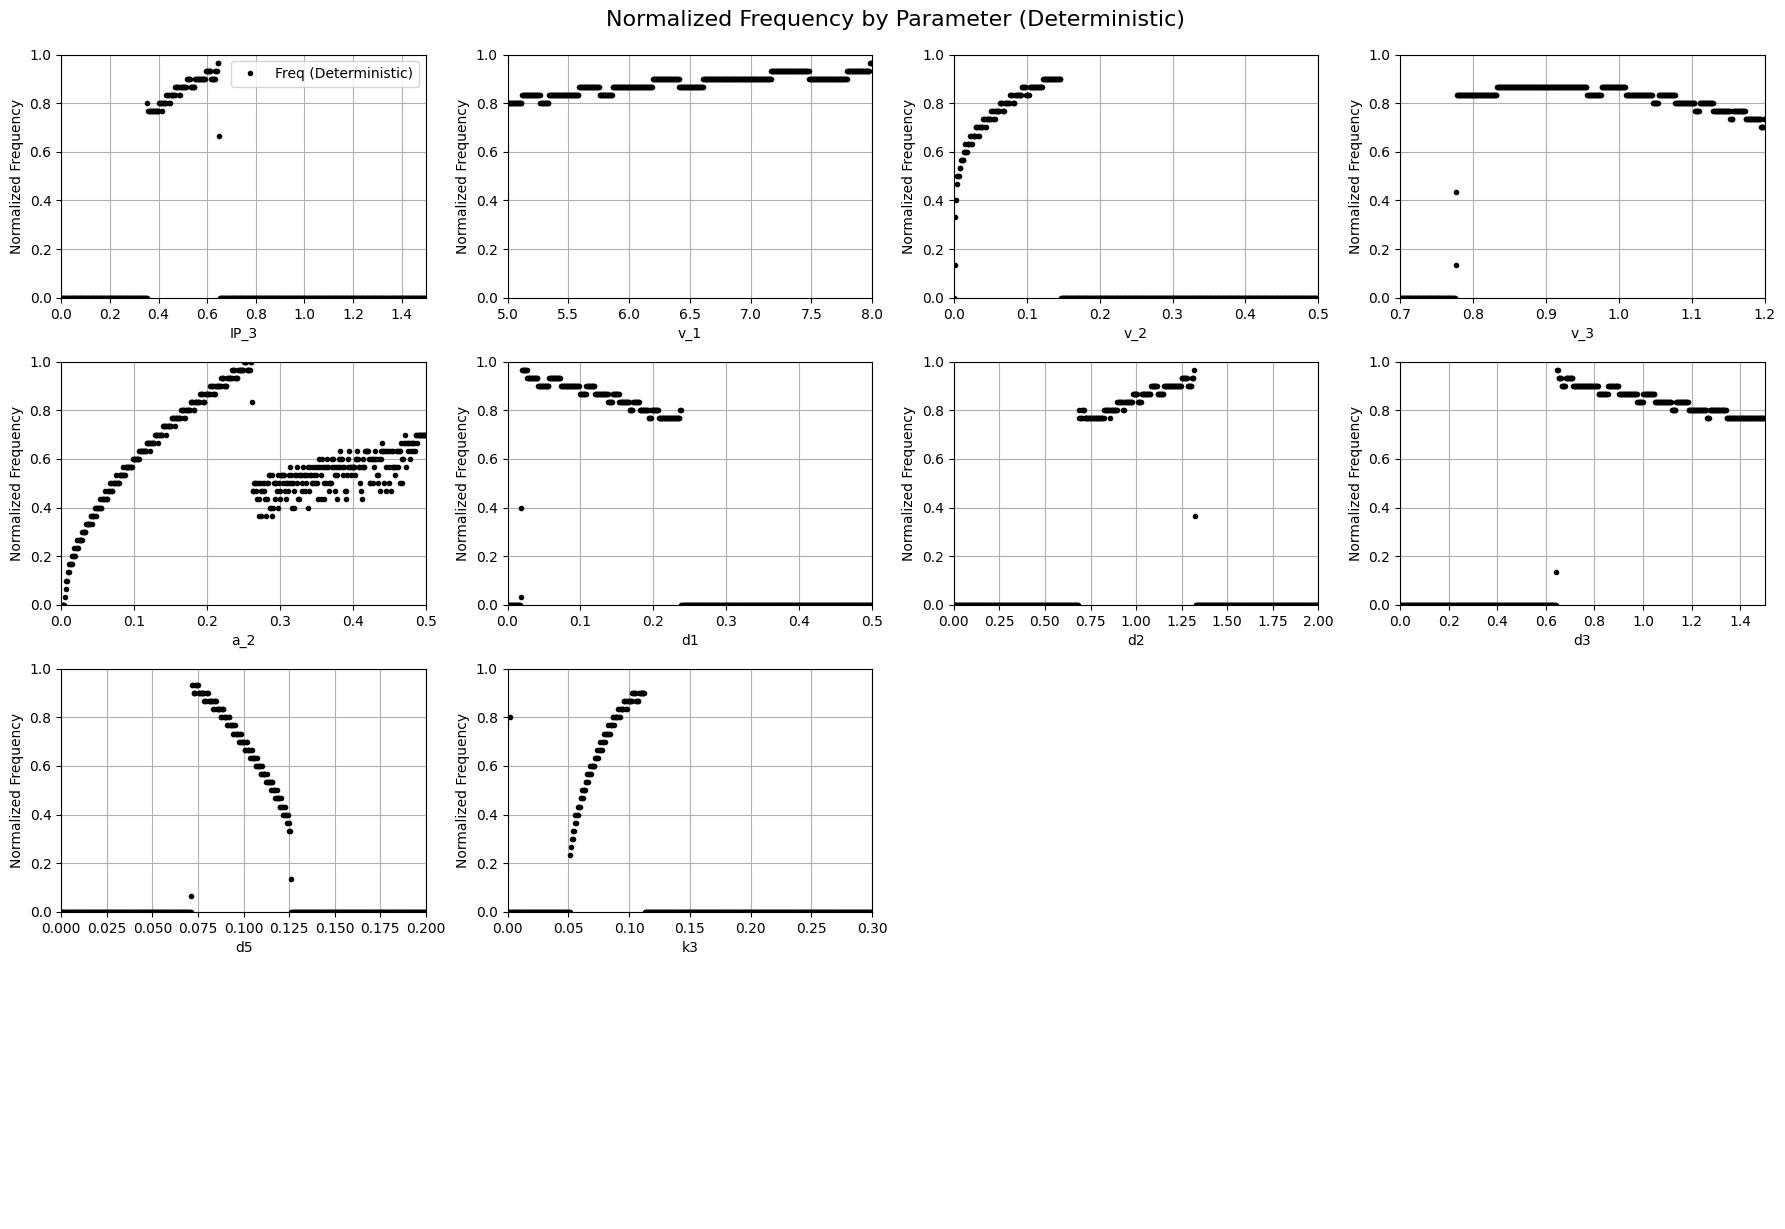

In [9]:
Min_Ca, Max_Ca, Freq_Ca, _, PD = min, max, freq, auc, pd

# Normalize frequency data
Freq_Ca = Freq_Ca / np.nanmax(Freq_Ca)

# Parameter names
Lnames = ['IP_3', 'v_1', 'v_2', 'v_3', 'a_2', 'd1', 'd2', 'd3', 'd5', 'k3']

# Plot bifurcation diagrams for each parameter
fig, axs = plt.subplots(4, 4, figsize=(18, 12))
axs = axs.flatten()

for iP in range(10):
    ax = axs[iP]
    ax.axvspan(PD[0, iP], PD[-1, iP], color='gray', alpha=0.3, label='Working Range')
    ax.plot(PD[:, iP], Max_Ca[:, iP], '.r', label='Max Ca (Deterministic)')
    ax.plot(PD[:, iP], Min_Ca[:, iP], '.b', label='Min Ca (Deterministic)')
    ax.set_xlim([PD[0, iP], PD[-1, iP]])
    ax.set_ylim([-0.1, 1])
    ax.set_xlabel(Lnames[iP])
    ax.set_ylabel('Ca²⁺')
    ax.grid(True)
    if iP == 0:
        ax.legend()

for i in range(10, 16):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle('Bifurcation Plots by Parameter (Deterministic)', fontsize=16, y=1.02)
plt.show()

# Frequency plot (normalized)
fig, axs = plt.subplots(4, 4, figsize=(18, 12))
axs = axs.flatten()

for iP in range(10):
    ax = axs[iP]
    ax.plot(PD[:, iP], Freq_Ca[:, iP], '.k', label='Freq (Deterministic)')
    ax.set_xlim([PD[0, iP], PD[-1, iP]])
    ax.set_ylim([0, 1])
    ax.set_xlabel(Lnames[iP])
    ax.set_ylabel('Normalized Frequency')
    ax.grid(True)
    if iP == 0:
        ax.legend()

for i in range(10, 16):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle('Normalized Frequency by Parameter (Deterministic)', fontsize=16, y=1.02)
plt.show()


In [2]:
def normalisation(k_Ca):
    min_Ca = np.min(k_Ca)
    max_Ca = np.max(k_Ca)
    return (k_Ca - min_Ca) / (max_Ca - min_Ca)

def lirinzel_ns(v2, a2, IP3, d5, k3):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 300, 0.1)
    dt = 0.1
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))
        
        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    Ca_norm = normalisation(Ca)

    return Ca_norm

In [3]:
v2_const = 0.075
a2_const = 0.125
IP3_const = 0.5
d5_const = 0.1
k3_const = 0.05

In [4]:
size1 = 100
v2 = np.linspace(0.01, 0.3, size1)
a2 = np.linspace(0.01, 0.5, size1)
IP3 = np.linspace(0.01, 1.5, size1)
d5 = np.linspace(0.01, 0.2, size1)
k3 = np.linspace(0.01, 0.3, size1)

In [5]:
Ca_matrix_v2 = []
for i in range(size1):
    Ca = lirinzel_ns(v2[i], a2_const, IP3_const, d5_const, k3_const)
    Ca_matrix_v2.append(Ca)

Ca_matrix_v2 = np.array(Ca_matrix_v2)

In [6]:
Ca_matrix_a2 = []
for i in range(size1):
    Ca = lirinzel_ns(v2_const, a2[i], IP3_const, d5_const, k3_const)
    Ca_matrix_a2.append(Ca)

Ca_matrix_a2 = np.array(Ca_matrix_a2)

In [7]:
Ca_matrix_IP3 = []
for i in range(size1):
    Ca = lirinzel_ns(v2_const, a2_const, IP3[i], d5_const, k3_const)
    Ca_matrix_IP3.append(Ca)

Ca_matrix_IP3 = np.array(Ca_matrix_IP3)

In [8]:
Ca_matrix_d5 = []
for i in range(size1):
    Ca = lirinzel_ns(v2_const, a2_const, IP3_const, d5[i], k3_const)
    Ca_matrix_d5.append(Ca)

Ca_matrix_d5 = np.array(Ca_matrix_d5)

In [9]:
Ca_matrix_k3 = []
for i in range(size1):
    Ca = lirinzel_ns(v2_const, a2_const, IP3_const, d5_const, k3[i])
    Ca_matrix_k3.append(Ca)

Ca_matrix_k3 = np.array(Ca_matrix_k3)

C:\Users\asus2\AppData\Local\Temp\ipykernel_12220\1052778074.py:24: RuntimeWarning: overflow encountered in scalar multiply
  dh = alphah * (1 - h[-1]) - betah * h[-1]
C:\Users\asus2\AppData\Local\Temp\ipykernel_12220\1052778074.py:25: RuntimeWarning: overflow encountered in scalar power
  dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
C:\Users\asus2\AppData\Local\Temp\ipykernel_12220\1052778074.py:27: RuntimeWarning: overflow encountered in scalar power
  v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))
C:\Users\asus2\AppData\Local\Temp\ipykernel_12220\1052778074.py:27: RuntimeWarning: invalid value encountered in scalar divide
  v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))
C:\Users\asus2\AppData\Local\Temp\ipykernel_12220\1052778074.py:25: RuntimeWarning: overflow encountered in scalar multiply
  dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
C:\Users\asus2\AppData\Local\Temp\ipykernel_12220\1052778074.py:18: RuntimeWarning: invalid value encountered in scalar div

In [10]:
def filter(Ca_matrix):
    Ca_max = []
    Ca_min = []

    for i in range(size1):
        filtered_max = Ca_matrix[i][Ca_matrix[i] < 1]
        filtered_min = Ca_matrix[i][Ca_matrix[i] > 0]
        
        # Use NaN or some placeholder if the filtered array is empty
        Ca_max.append(np.max(filtered_max) if filtered_max.size > 0 else np.nan)
        Ca_min.append(np.min(filtered_min) if filtered_min.size > 0 else np.nan)

    Ca_max = np.array(Ca_max)
    Ca_min = np.array(Ca_min)

    return Ca_max, Ca_min

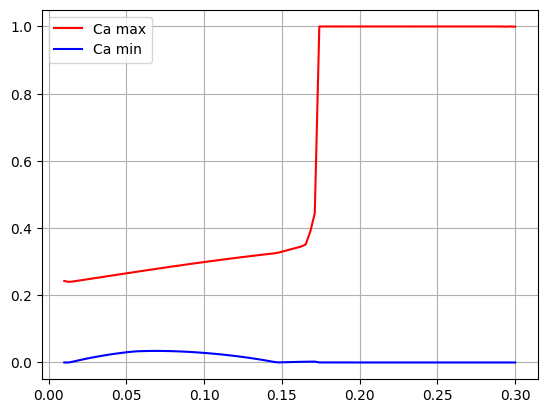

In [11]:
Ca_max_v2, Ca_min_v2 = filter(Ca_matrix_v2)
plt.plot(v2, Ca_max_v2, c='red', label="Ca max")
plt.plot(v2, Ca_min_v2, c="blue", label="Ca min")
plt.grid()
plt.legend()
plt.show()

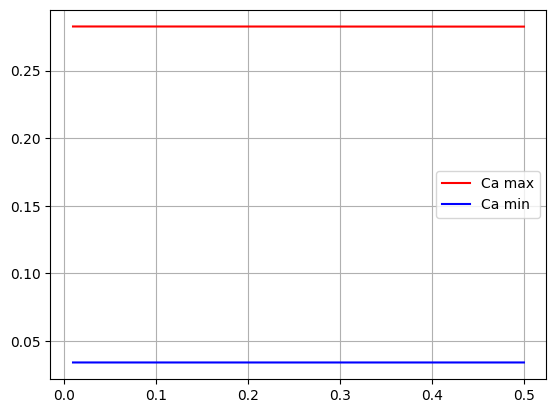

In [12]:
Ca_max_a2, Ca_min_a2 = filter(Ca_matrix_a2)
plt.plot(a2, Ca_max_a2, c='red', label="Ca max")
plt.plot(a2, Ca_min_a2, c="blue", label="Ca min")
plt.grid()
plt.legend()
plt.show()

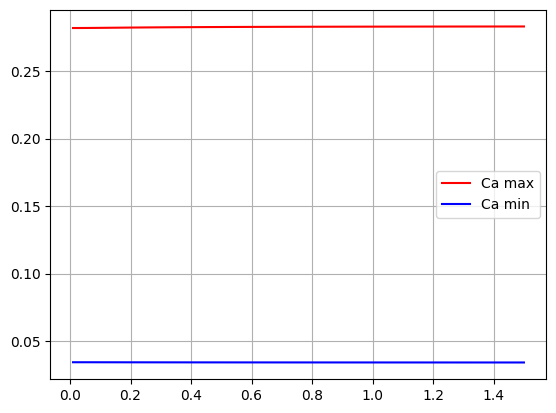

In [13]:
Ca_max_IP3, Ca_min_IP3 = filter(Ca_matrix_IP3)
plt.plot(IP3, Ca_max_IP3, c='red', label="Ca max")
plt.plot(IP3, Ca_min_IP3, c="blue", label="Ca min")
plt.grid()
plt.legend()
plt.show()

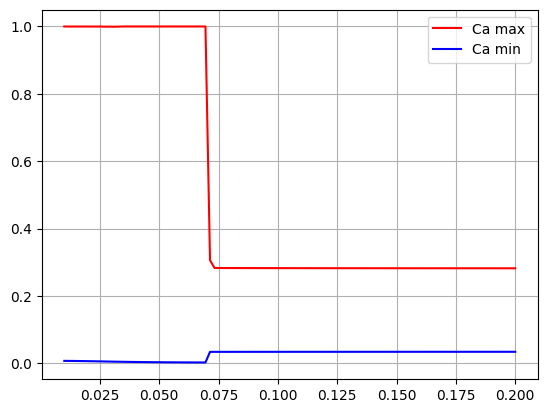

In [14]:
Ca_max_d5, Ca_min_d5 = filter(Ca_matrix_d5)
plt.plot(d5, Ca_max_d5, c='red', label="Ca max")
plt.plot(d5, Ca_min_d5, c="blue", label="Ca min")
plt.grid()
plt.legend()
plt.show()

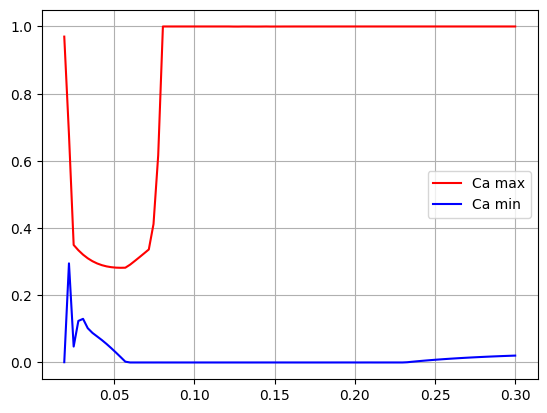

In [15]:
Ca_max_k3, Ca_min_k3 = filter(Ca_matrix_k3)
plt.plot(k3, Ca_max_k3, c='red', label="Ca max")
plt.plot(k3, Ca_min_k3, c="blue", label="Ca min")
plt.grid()
plt.legend()
plt.show()

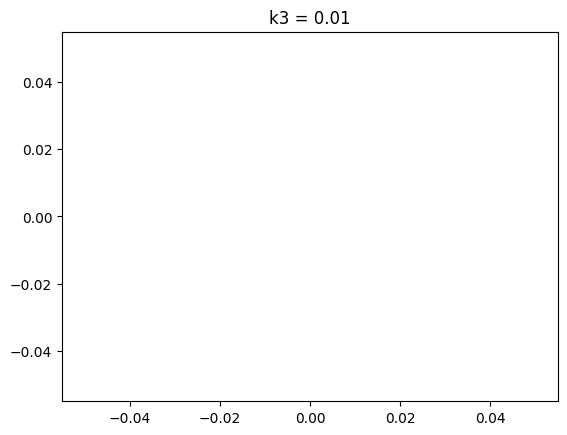

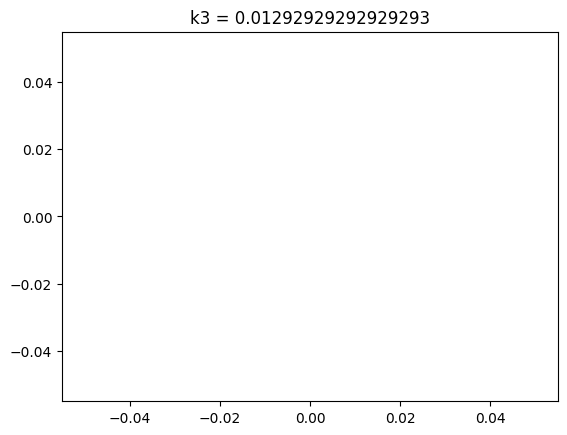

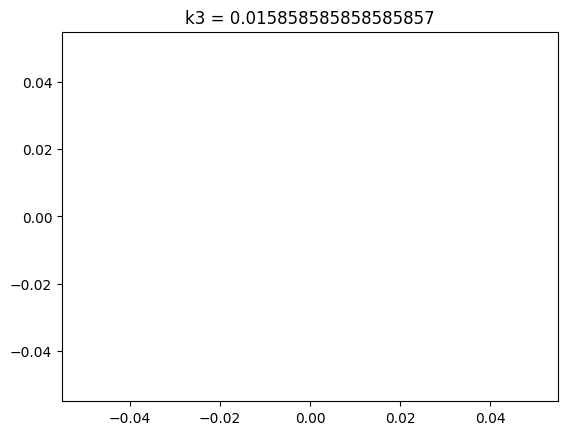

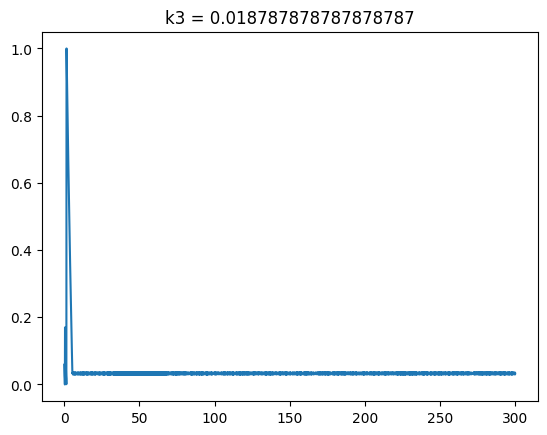

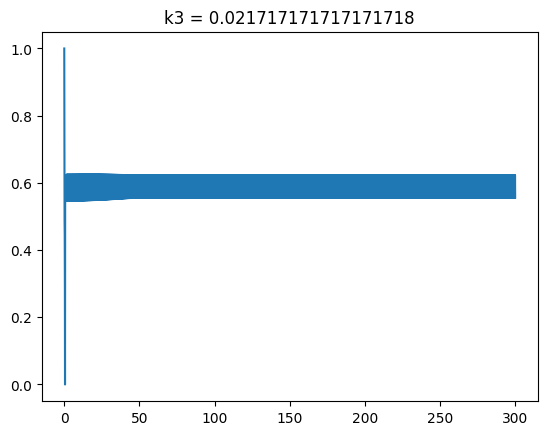

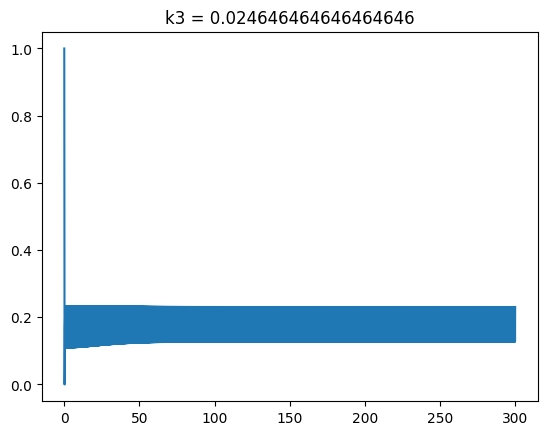

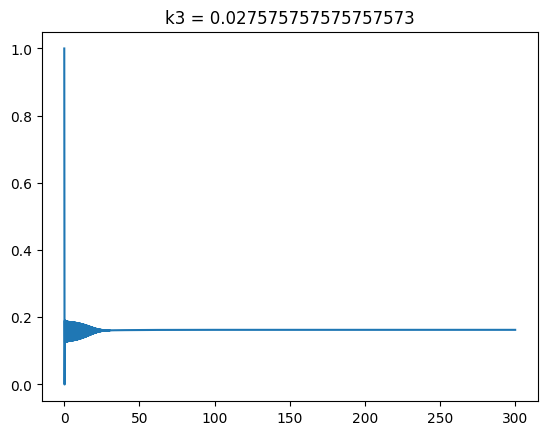

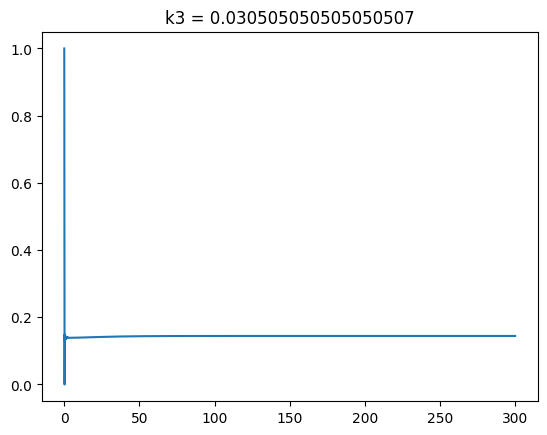

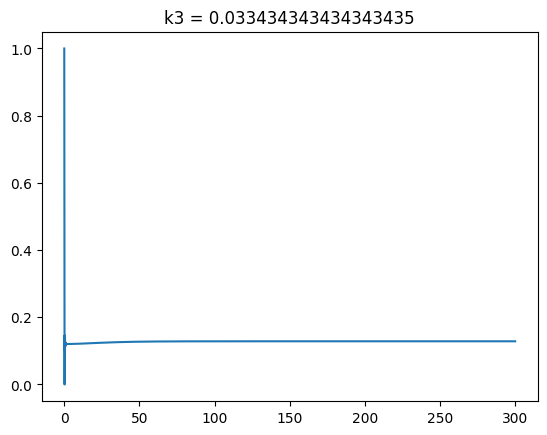

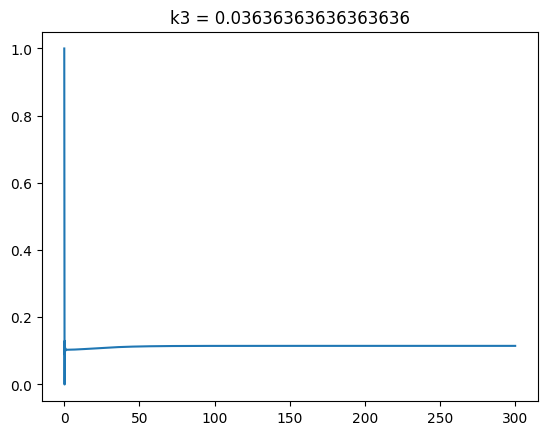

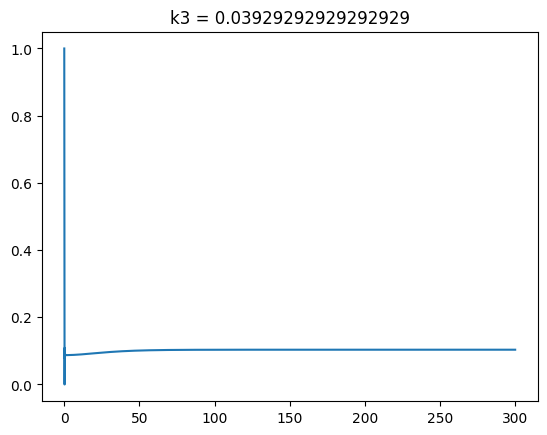

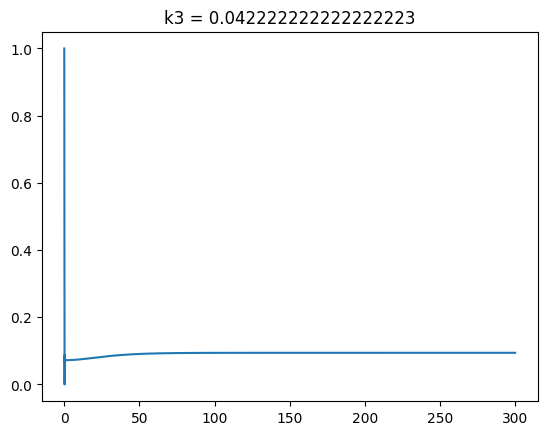

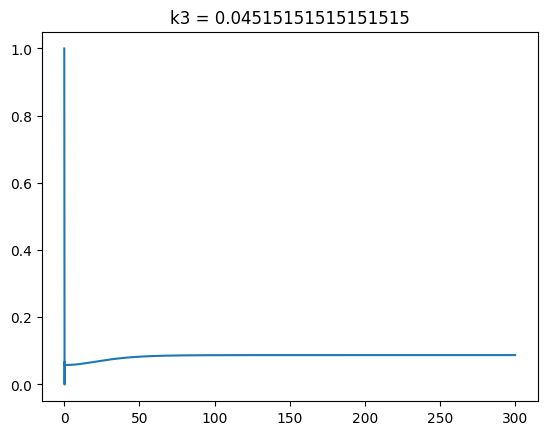

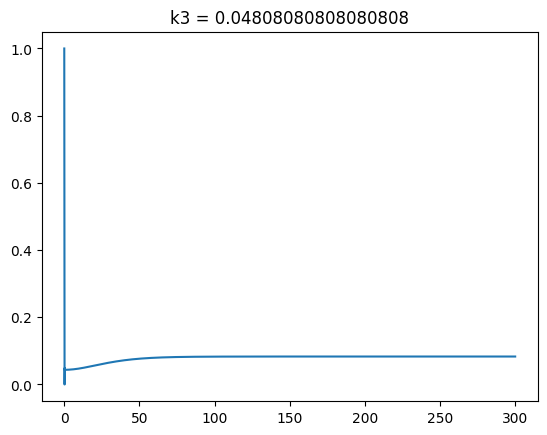

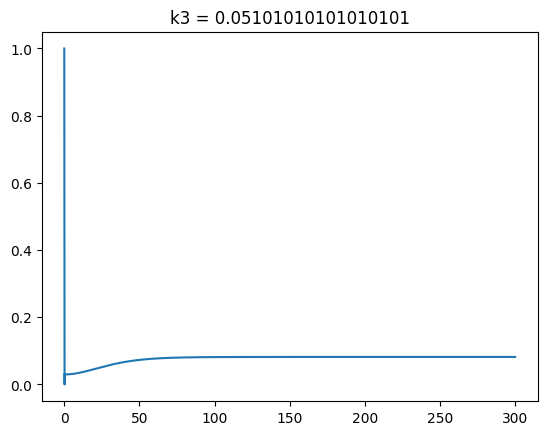

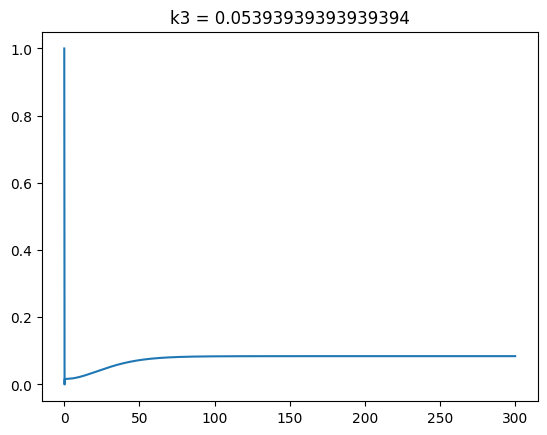

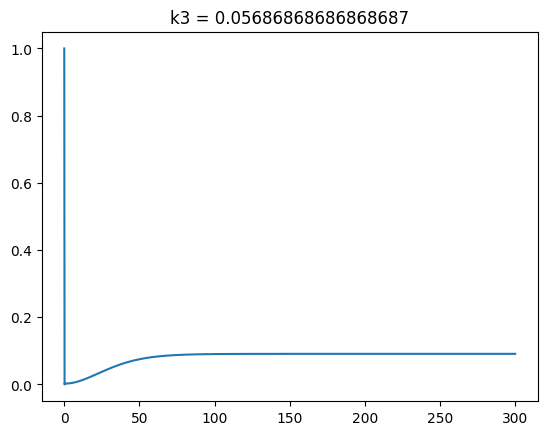

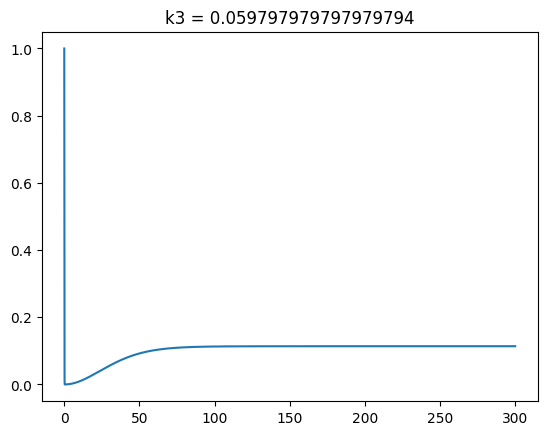

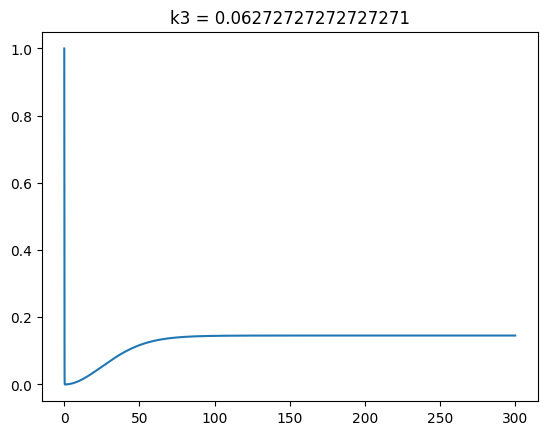

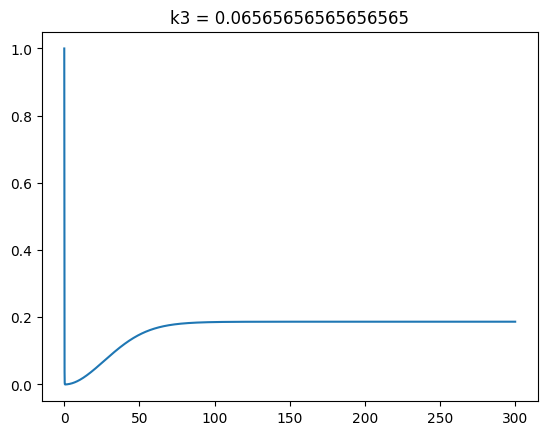

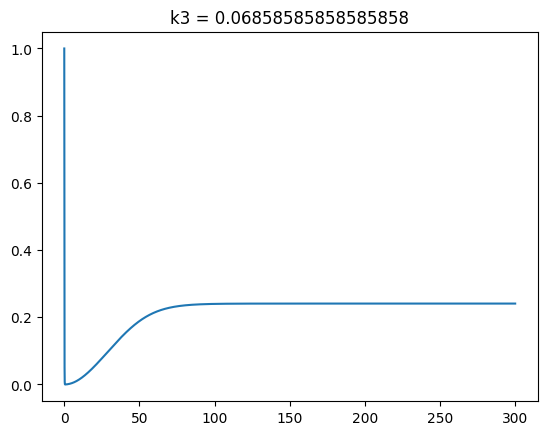

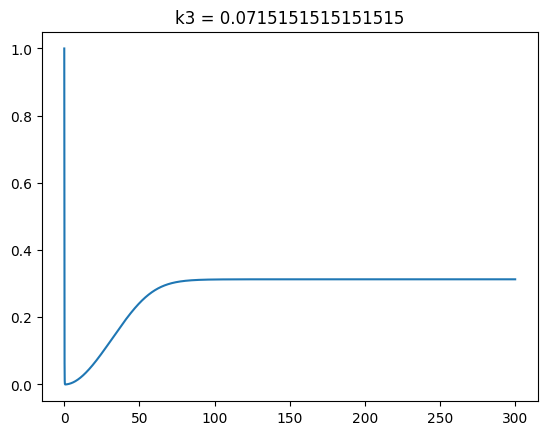

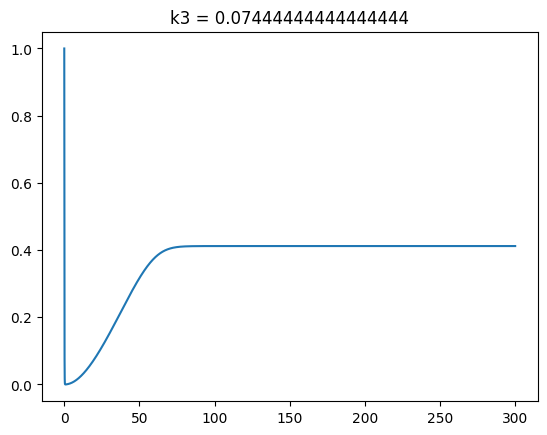

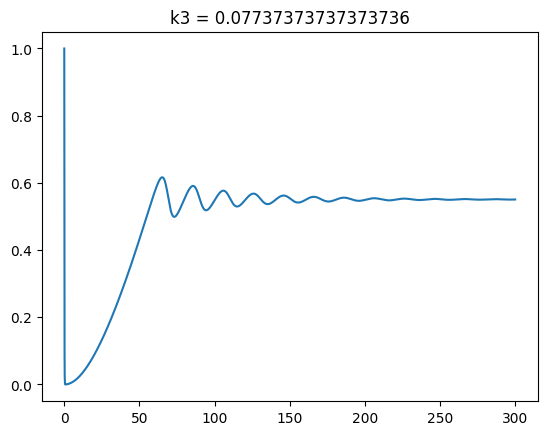

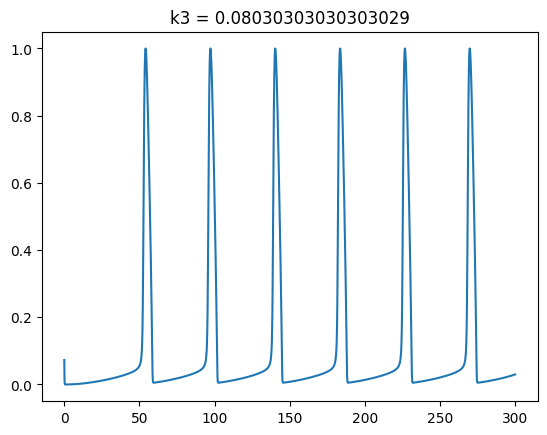

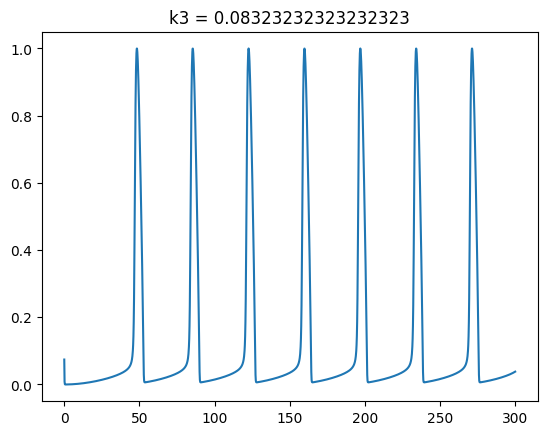

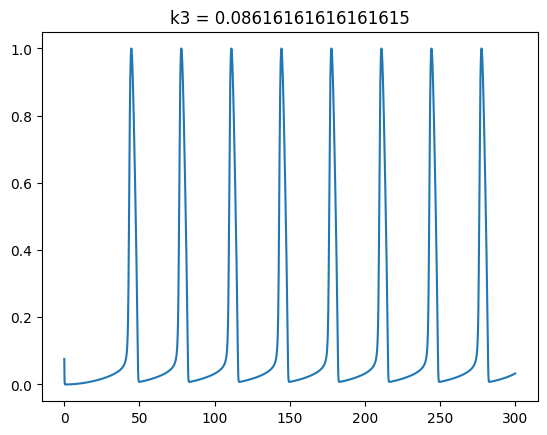

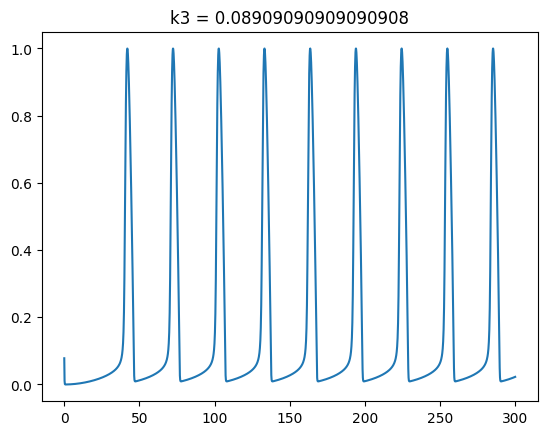

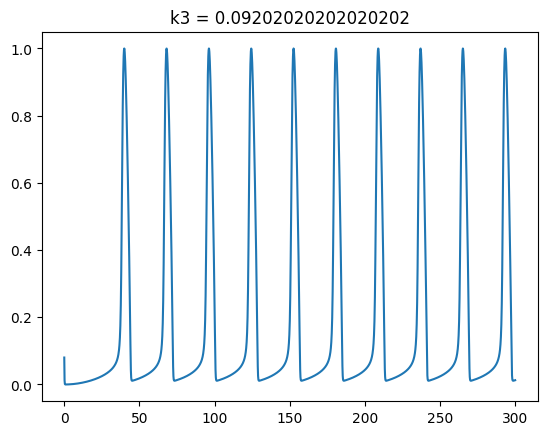

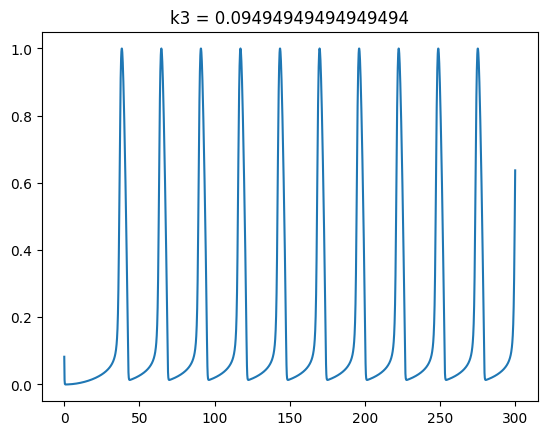

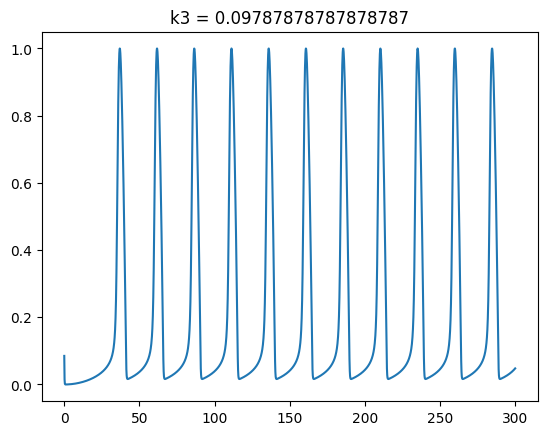

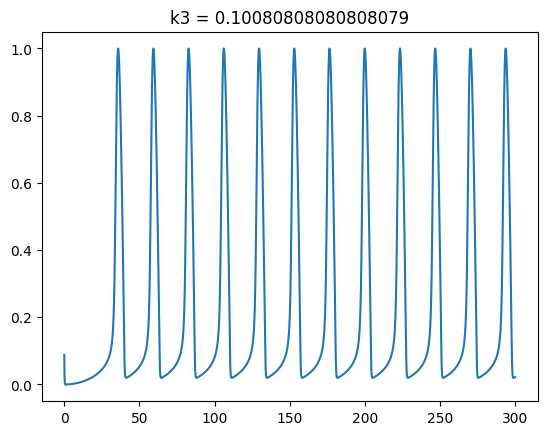

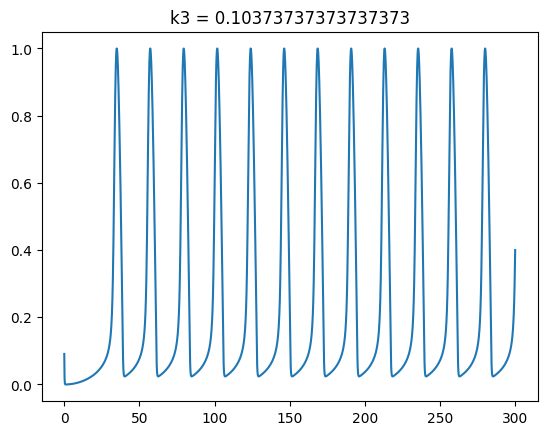

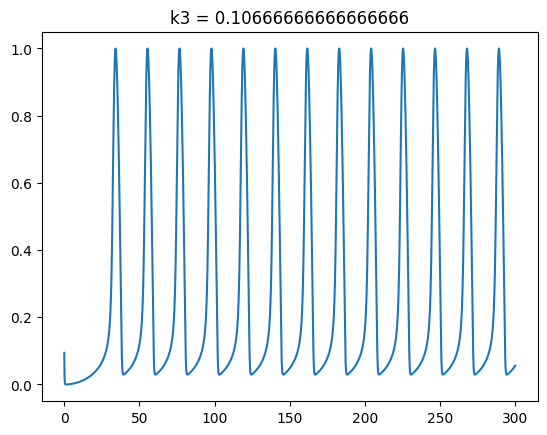

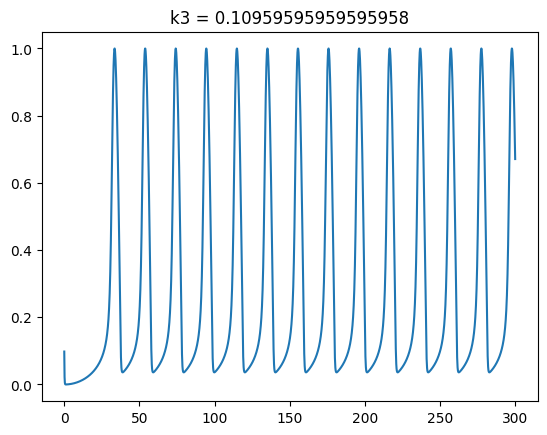

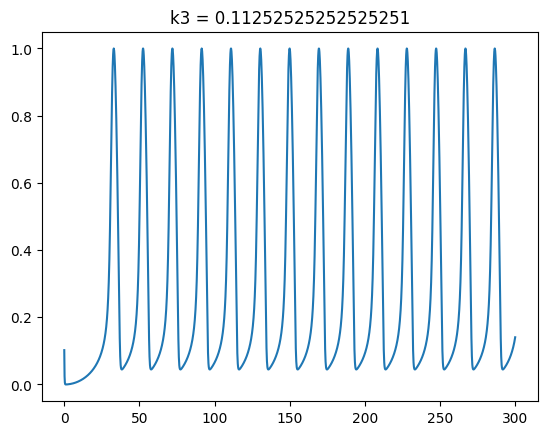

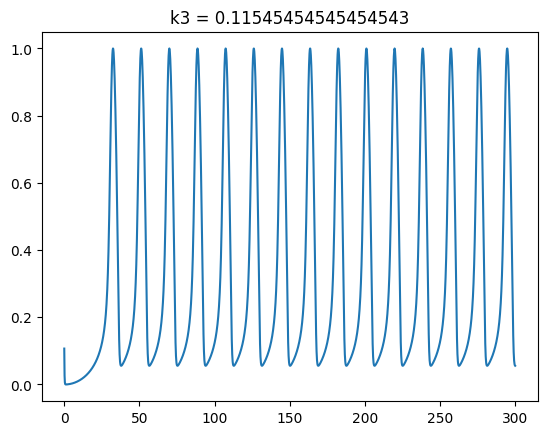

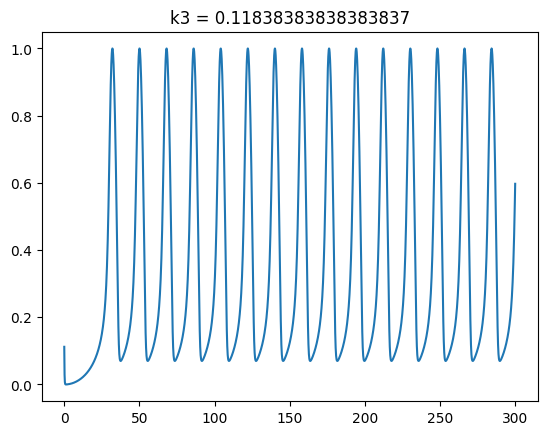

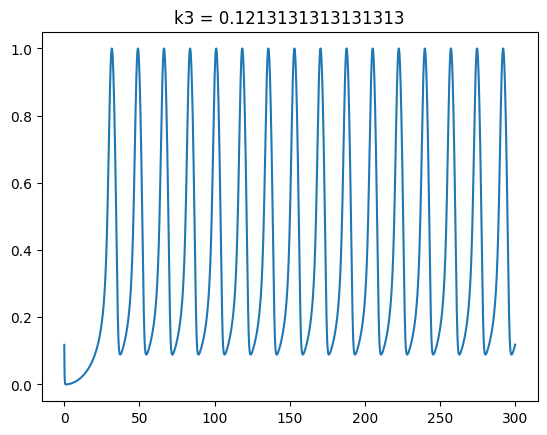

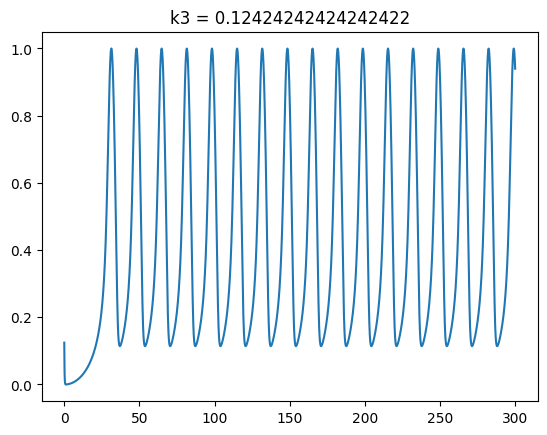

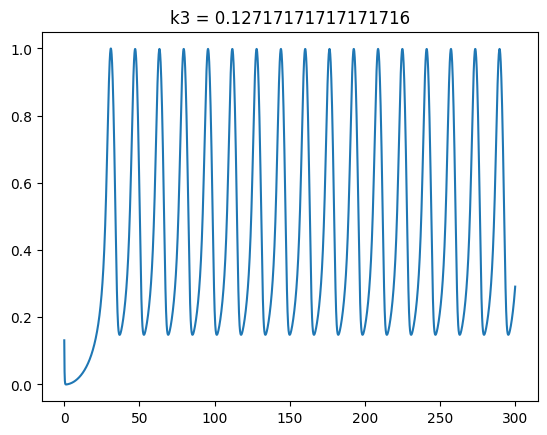

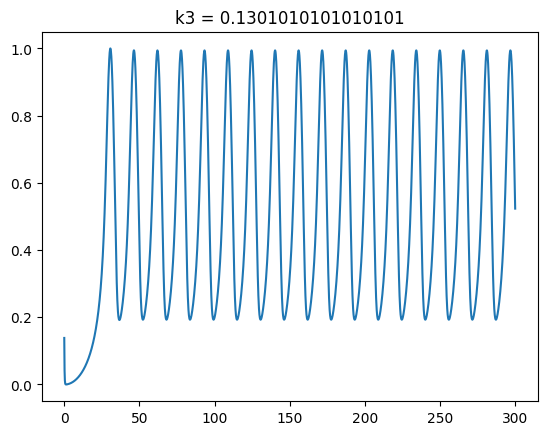

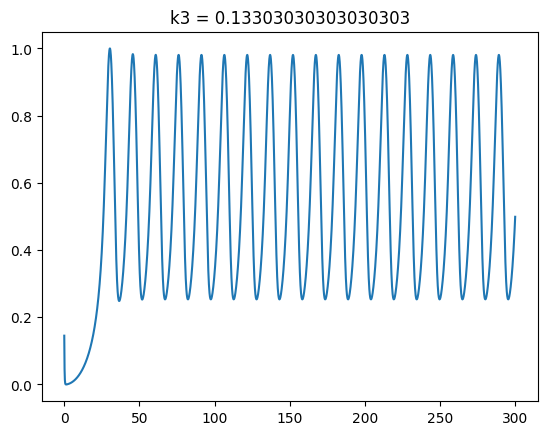

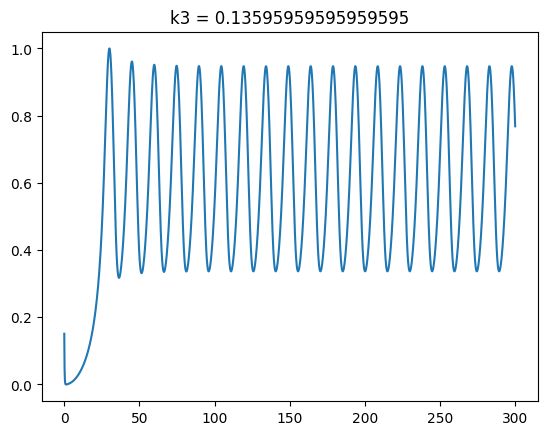

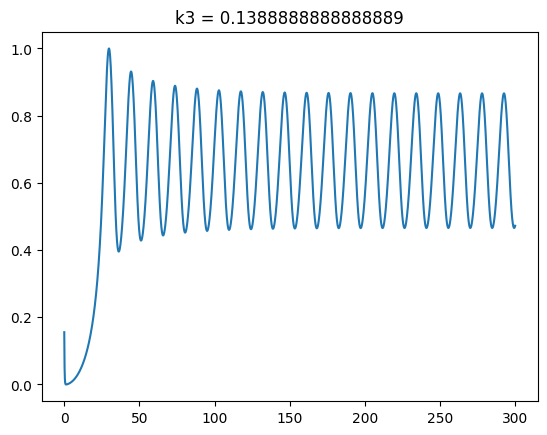

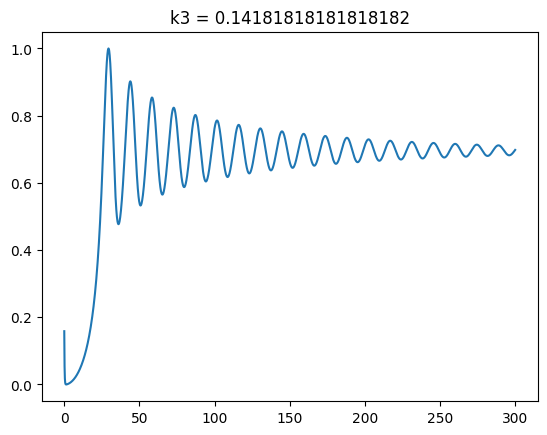

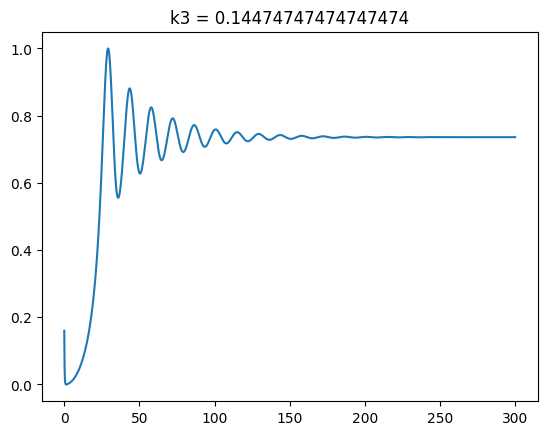

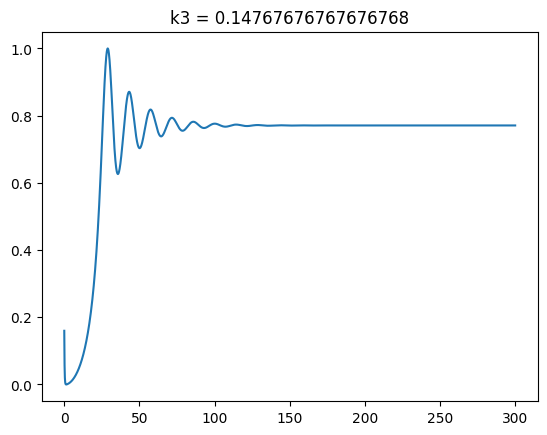

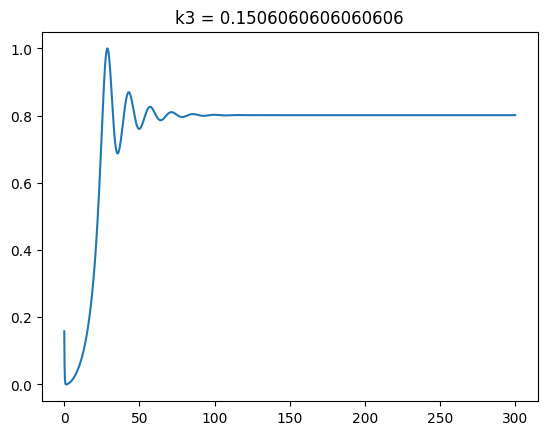

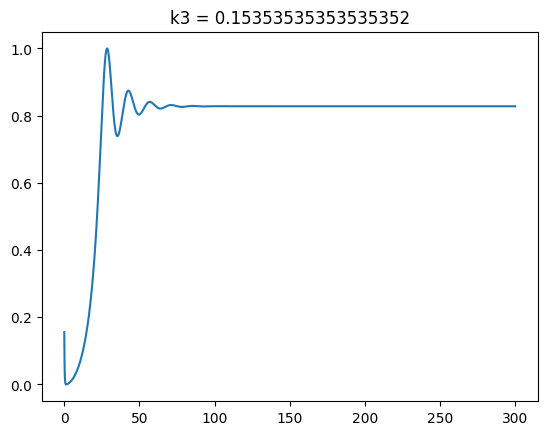

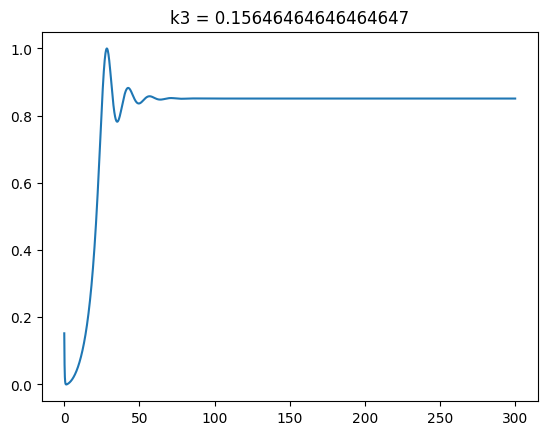

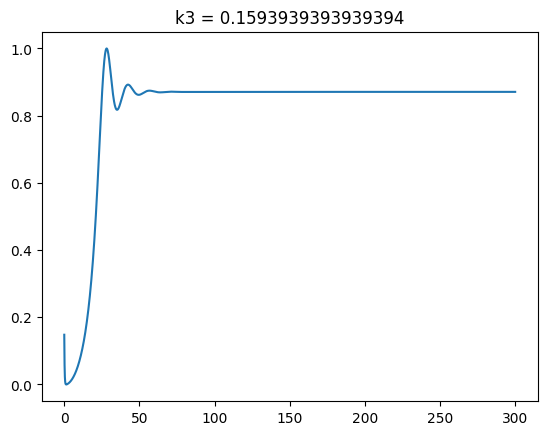

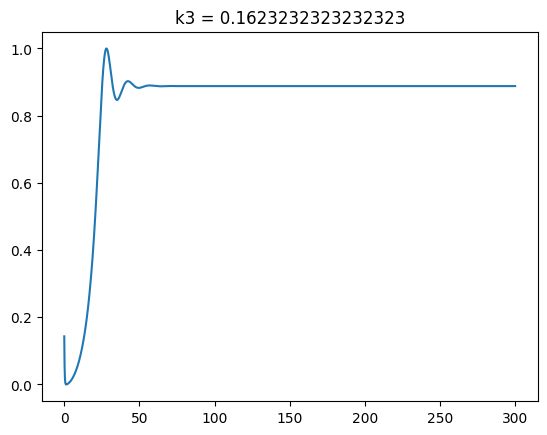

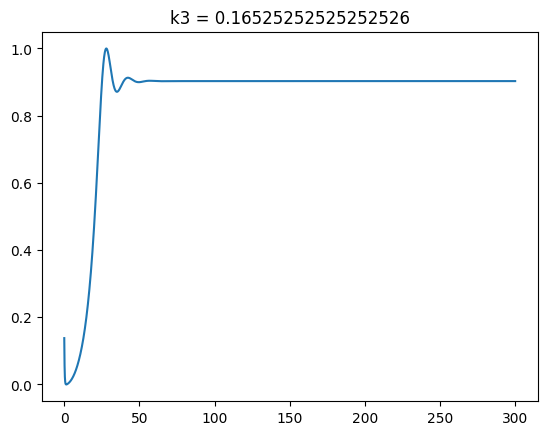

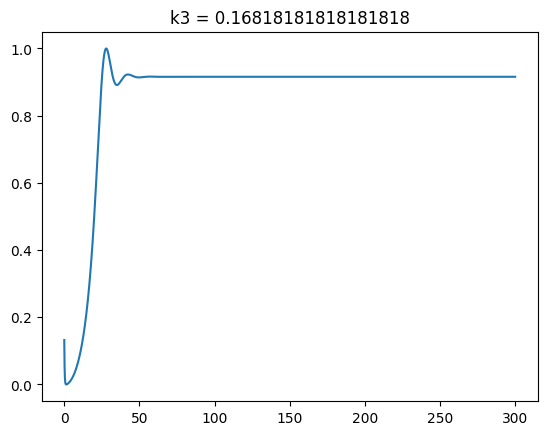

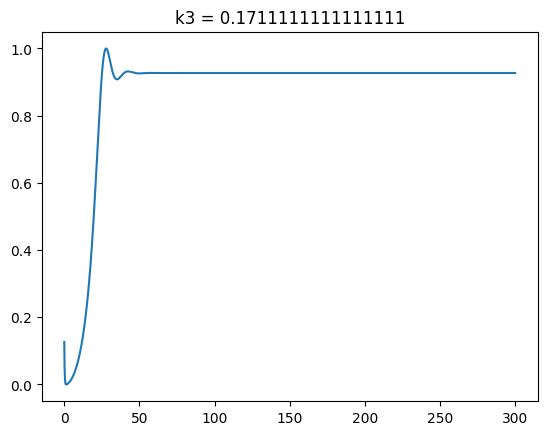

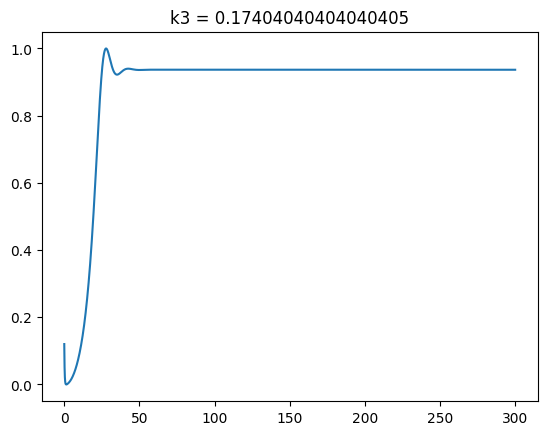

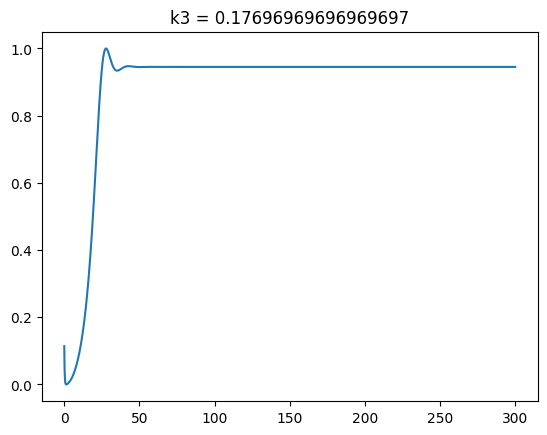

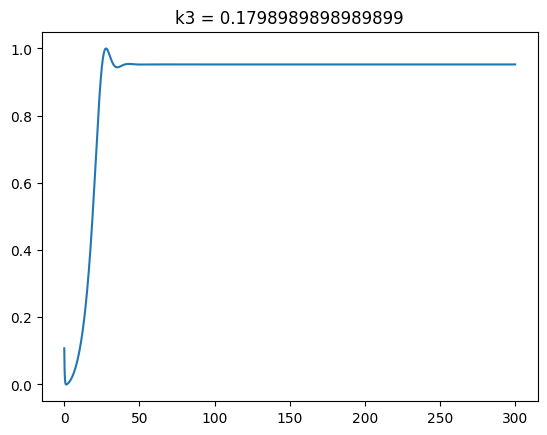

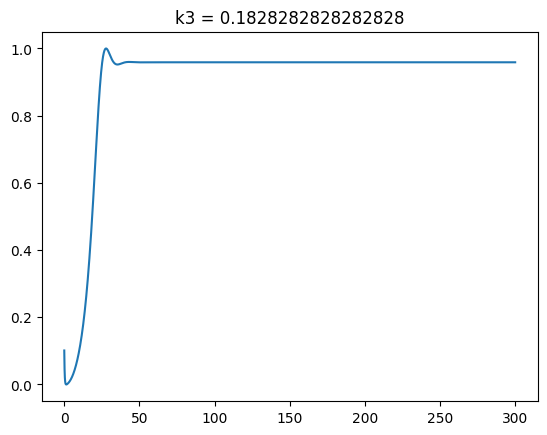

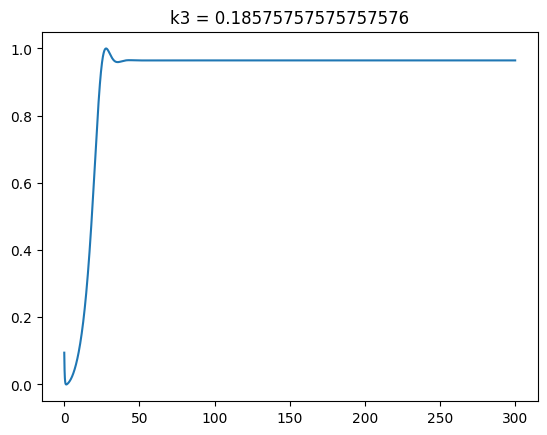

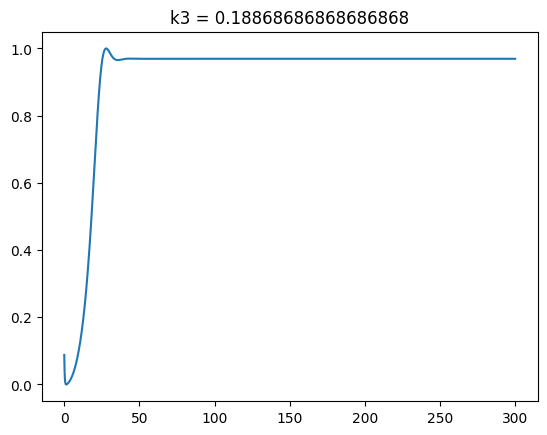

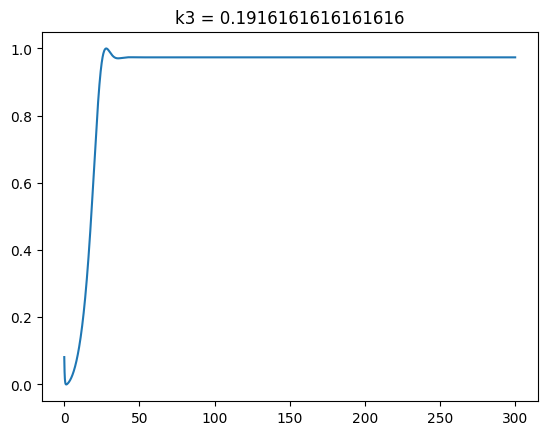

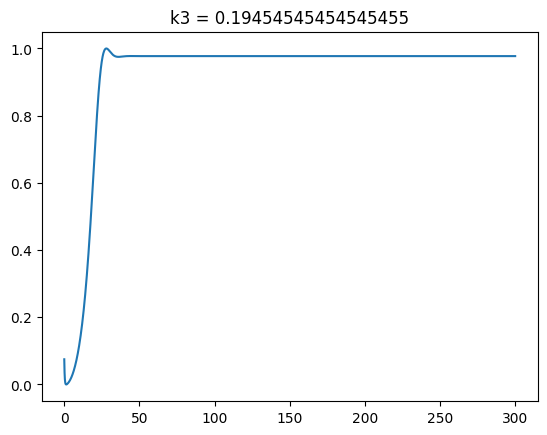

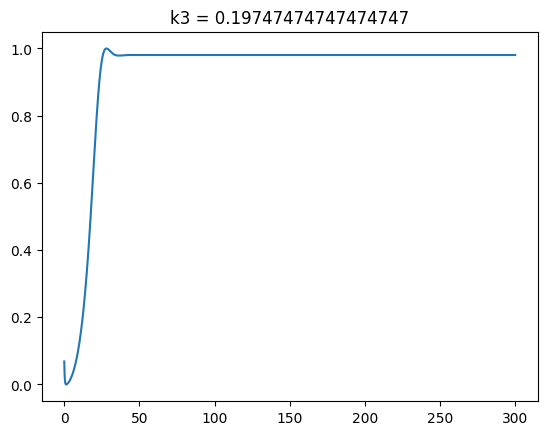

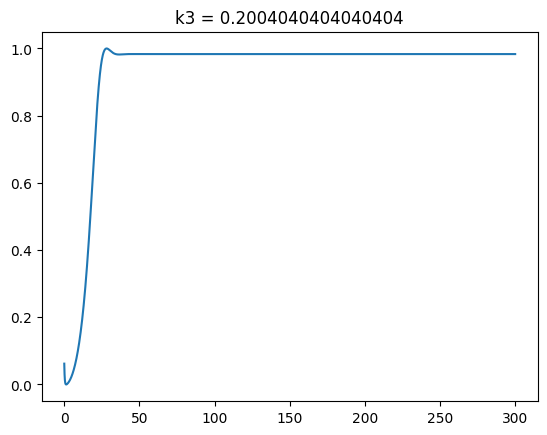

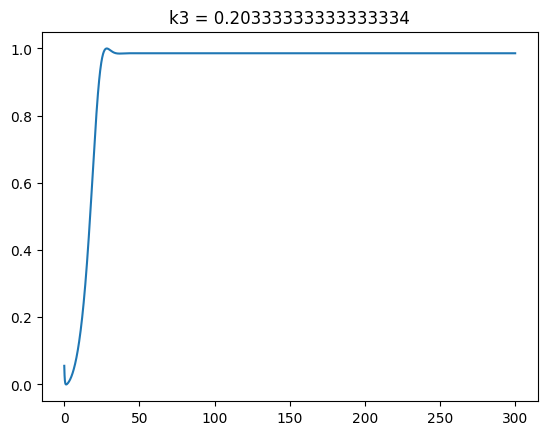

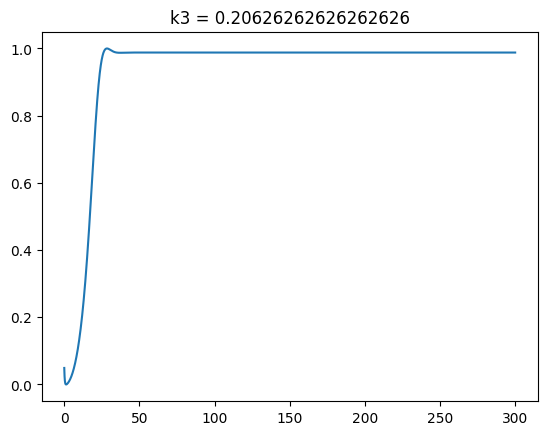

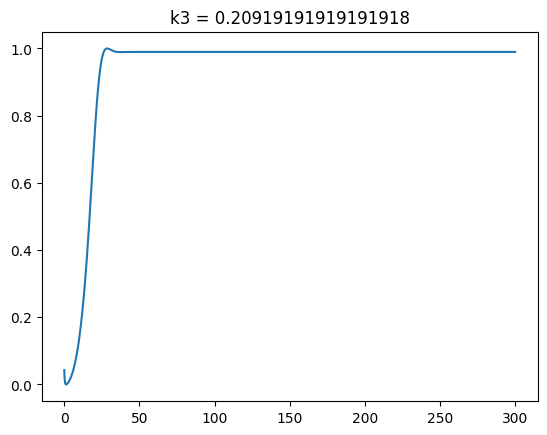

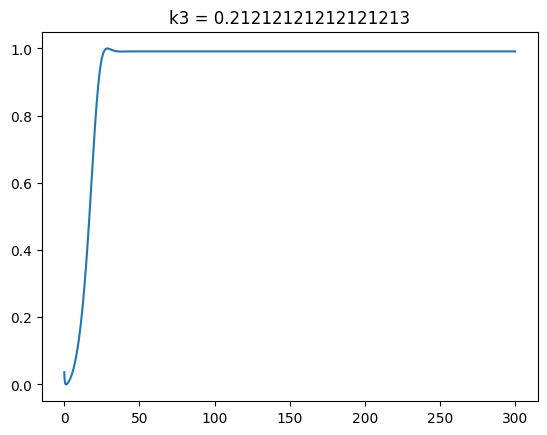

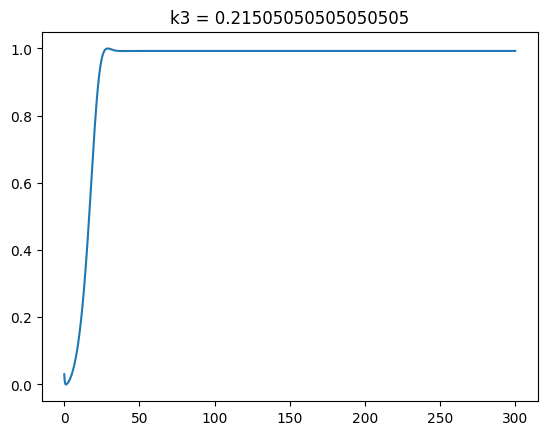

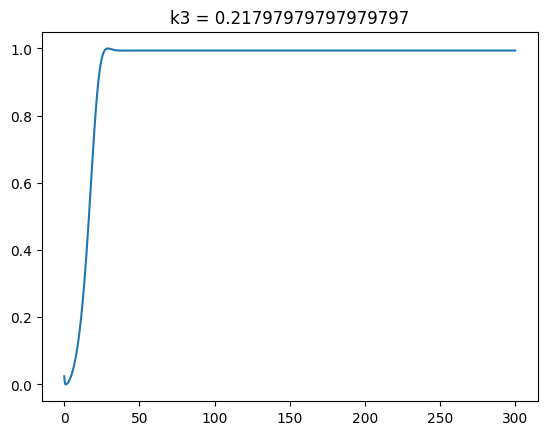

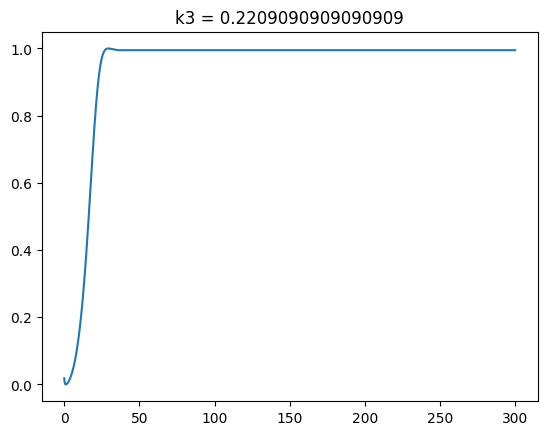

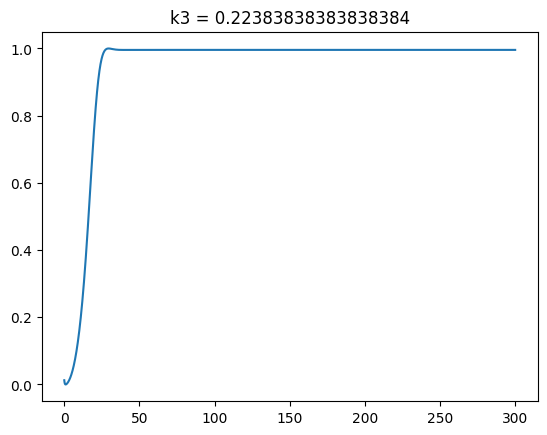

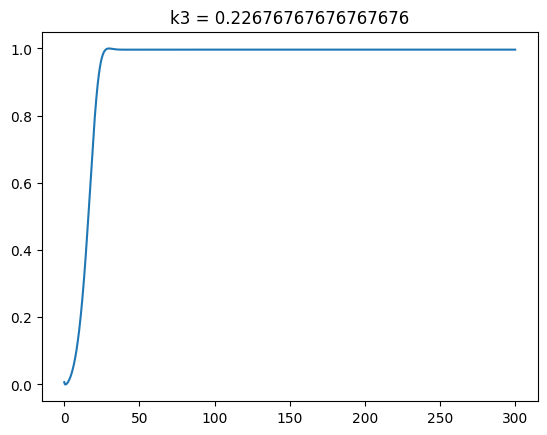

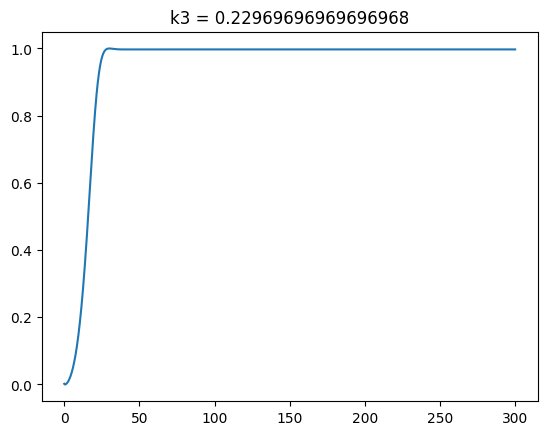

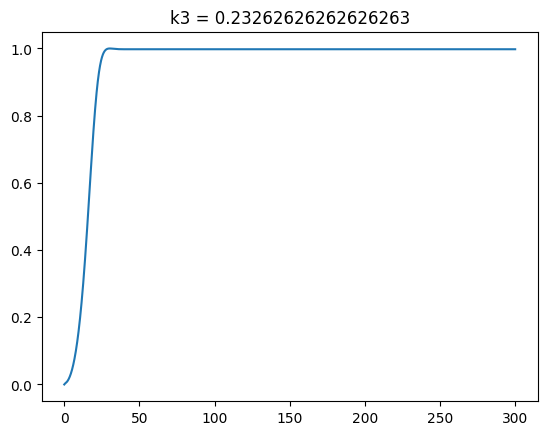

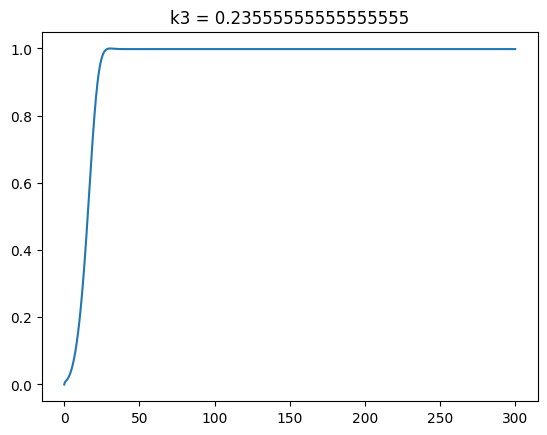

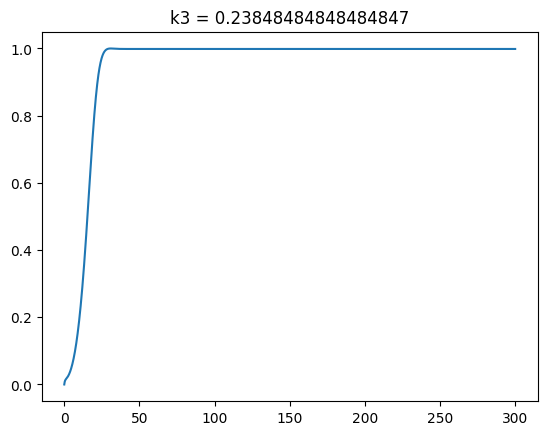

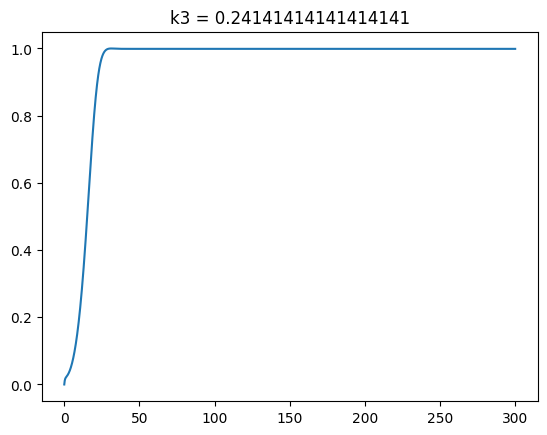

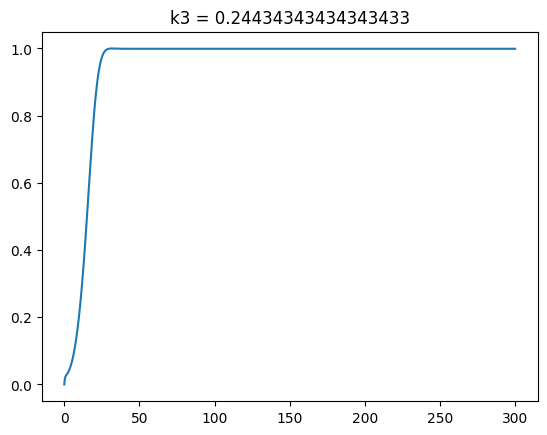

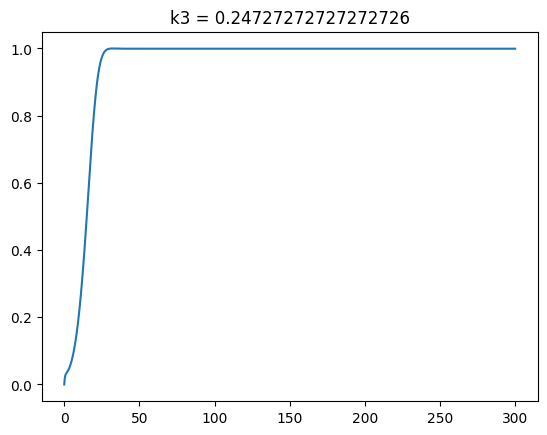

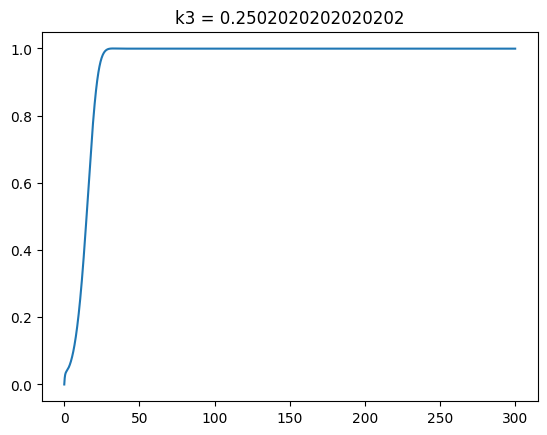

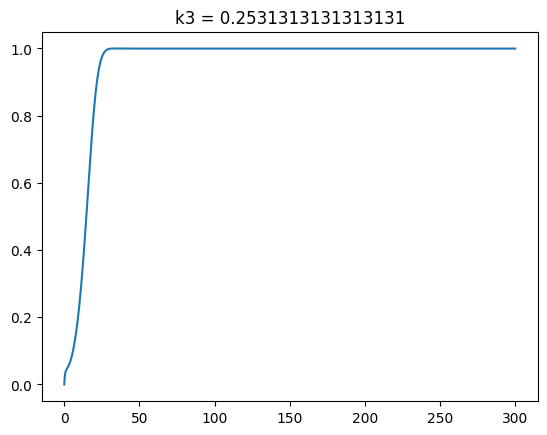

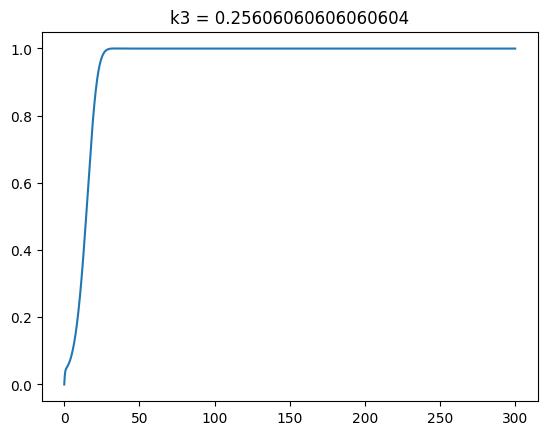

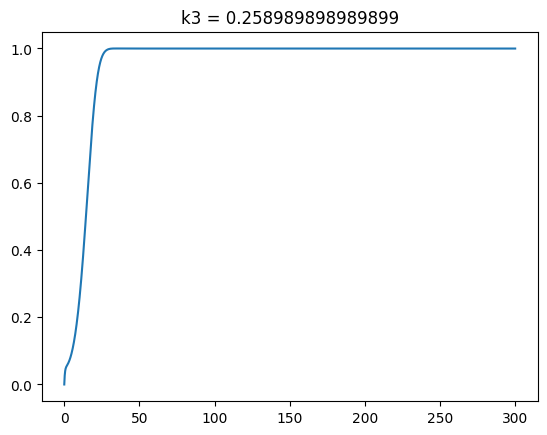

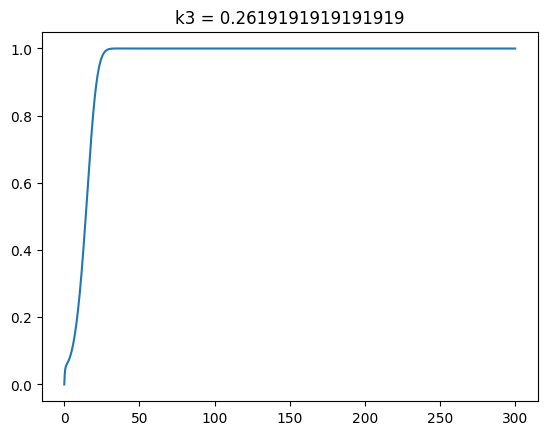

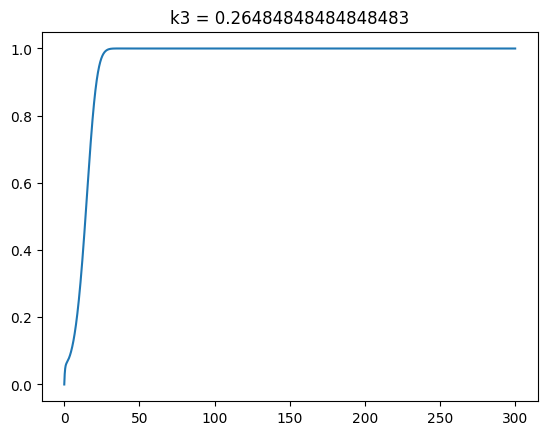

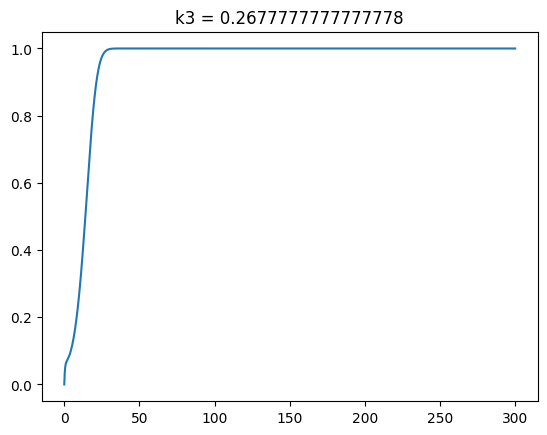

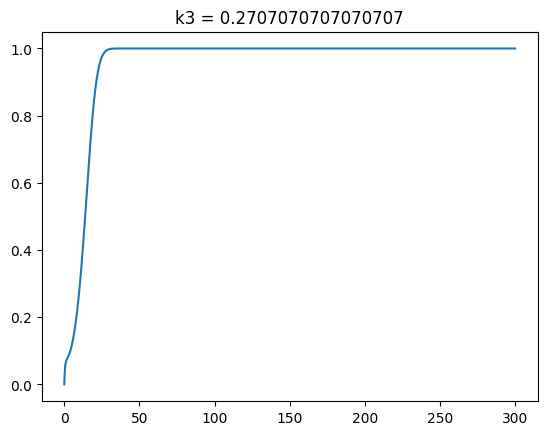

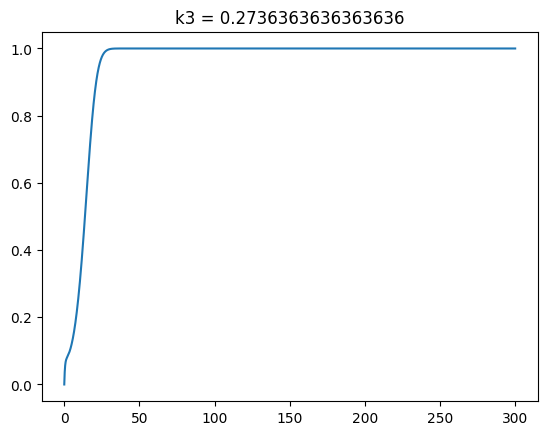

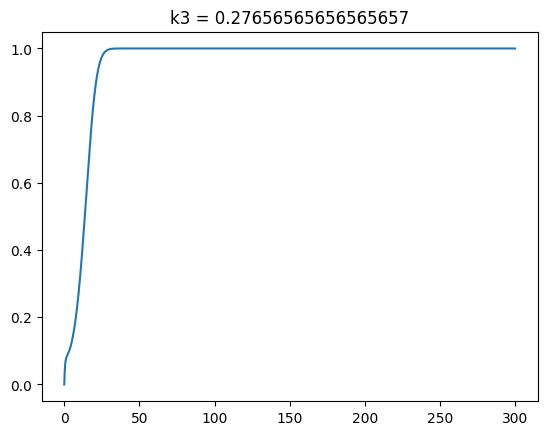

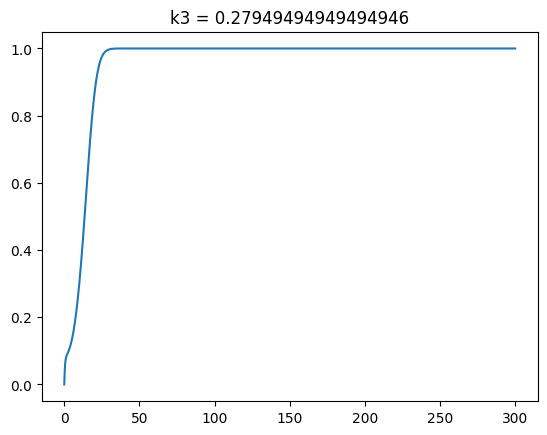

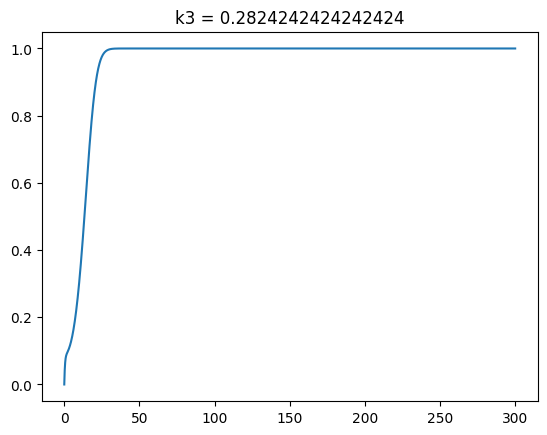

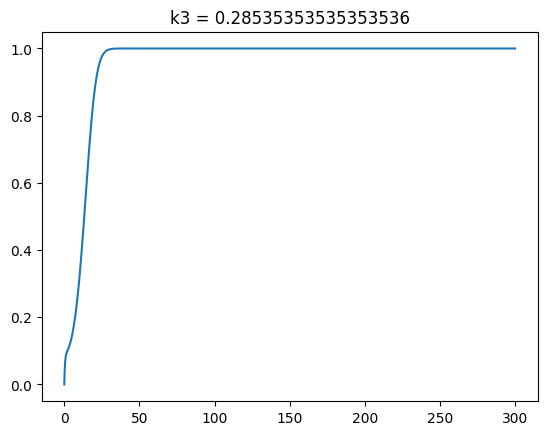

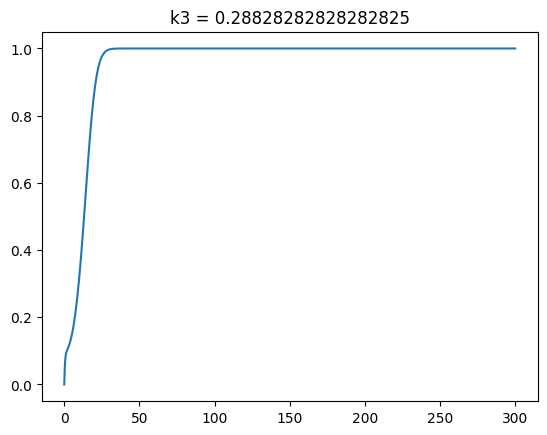

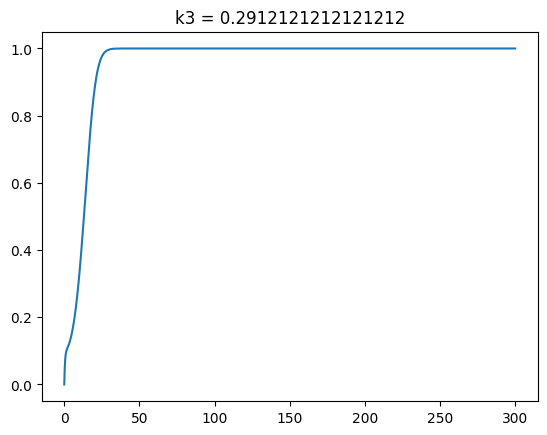

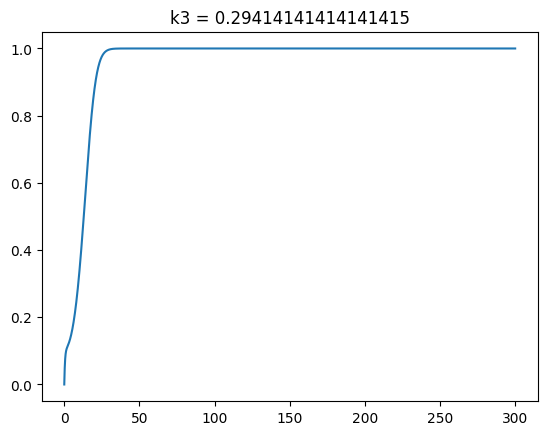

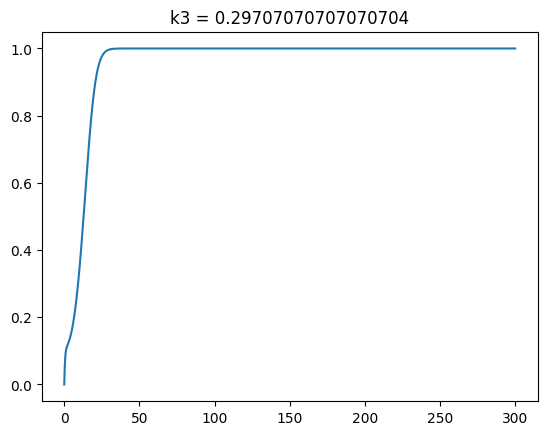

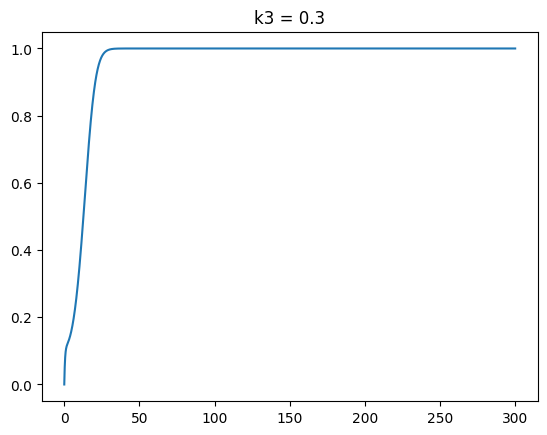

In [17]:
time = np.arange(0, 300, 0.1)
for i in range(size1):
    plt.plot(time, Ca_matrix_k3[i])
    plt.title(f"k3 = {k3[i]}")
    plt.show()